In [79]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Input, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [2]:
data = pd.read_csv('./fer2013.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [39]:
# data_train.loc[data_train.emotion==1]

Text(0.5,1,'1')

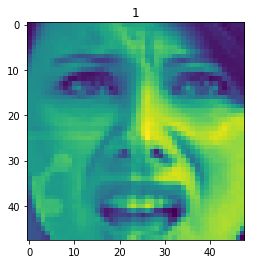

In [38]:
index = 533
img_array = np.array(data.pixels[index].split(" "), dtype='int')
img_array = img_array.reshape((48,48))
img_array = img_array
img = Image.fromarray(img_array)
plt.imshow(img_array)
plt.title(data.emotion[index])

In [19]:
data.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [20]:
data_train = data.loc[data.Usage=='Training']
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 0 to 28708
Data columns (total 3 columns):
emotion    28709 non-null int64
pixels     28709 non-null object
Usage      28709 non-null object
dtypes: int64(1), object(2)
memory usage: 897.2+ KB


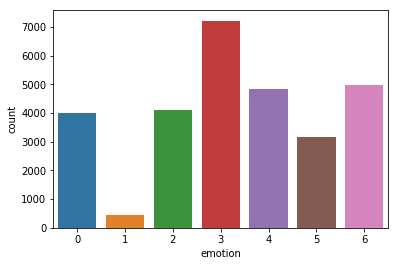

In [35]:
sns.countplot(data_train.emotion)

In [24]:
X = []
for row in tqdm(data_train.pixels):
    X.append([int(pixel) for pixel in row.split(" ")])
X = np.reshape(np.array(X), (-1, 48, 48, 1))
X = X/255
print(X.shape)

100%|███████████████████████████████████████████████████████████████████████████| 28709/28709 [01:32<00:00, 311.76it/s]


(28709, 48, 48, 1)


In [30]:
classes = data_train.emotion.max() + 1
print(data_train.emotion.unique())
lkup = np.eye(classes)

[0 2 4 6 3 5 1]


In [31]:
y = [lkup[index] for index in data_train.emotion]
y = np.array(y)
y.shape

(28709, 7)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22967, 48, 48, 1), (5742, 48, 48, 1), (22967, 7), (5742, 7))

In [90]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

datagen_test = ImageDataGenerator()

datagen_test.fit(X_test)

C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (22967, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (5742, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [99]:
inputs = Input(shape=(48, 48, 1))

conv = Conv2D(filters= 32, kernel_size= (3,3), padding='same', activation='relu')(inputs)
conv = MaxPooling2D(pool_size=(2,2), padding='same')(conv)
conv = BatchNormalization()(conv)

conv = Conv2D(filters= 32, kernel_size= (2,2), padding='same', activation='relu')(conv)
conv = MaxPooling2D(pool_size=(2,2), padding='same')(conv)
conv = BatchNormalization()(conv)

conv = Conv2D(filters= 64, kernel_size= (2,2), padding='same', activation='relu')(conv)
conv = MaxPooling2D(pool_size=(2,2), padding='same')(conv)
conv = BatchNormalization()(conv)

conv = Conv2D(filters= 128, kernel_size= (2,2), padding='same', activation='relu')(conv)
conv = MaxPooling2D(pool_size=(2,2), padding='same')(conv)
conv = BatchNormalization()(conv)

conv = GlobalAveragePooling2D()(conv)
# conv = Flatten()(conv)

dense = Dense(100, activation='relu')(conv)
# dense = Dense(100, activation='relu')(dense)
dense = Dense(classes, activation='softmax')(dense)

cnn = Model(inputs=inputs, outputs=dense)
cnn.summary()

cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 24, 24, 32)        4128      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 12, 12, 32)        128       
_________

In [ ]:
cbs = [TQDMNotebookCallback()]
#train_performance = cnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test),
#                           callbacks = cbs)
train_performance = cnn.fit_generator(datagen.flow(X_train, y_train, batch_size=64), epochs=50, 
                                      validation_data=datagen_test.flow(X_test, y_test), 
                                      steps_per_epoch =len(X_train) / 64, 
                                      validation_steps =len(X_train) / 64)

Epoch 1/5
359/358 [==============================] - ETA: 38s - loss: 1.5222 - acc: 0.4844 - ETA: 37s - loss: 1.6262 - acc: 0.3750 - ETA: 33s - loss: 1.6866 - acc: 0.3594 - ETA: 31s - loss: 1.7148 - acc: 0.3125 - ETA: 31s - loss: 1.7265 - acc: 0.3031 - ETA: 30s - loss: 1.7455 - acc: 0.2786 - ETA: 30s - loss: 1.7272 - acc: 0.2857 - ETA: 30s - loss: 1.7262 - acc: 0.2910

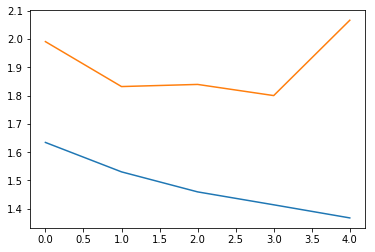

In [97]:
plt.plot(train_performance.history['loss'])
plt.plot(train_performance.history['val_loss'])
plt.show()

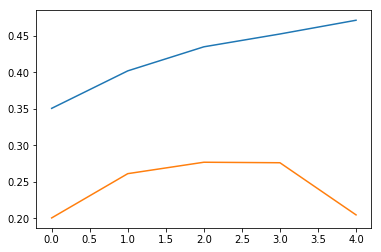

In [98]:
plt.plot(train_performance.history['acc'])
plt.plot(train_performance.history['val_acc'])
plt.show()